In [28]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
from mpl_toolkits import mplot3d
import pandas as pd
from sklearn.decomposition import PCA

## Topic 1 - PCA Introduction
### 1) Get the data

In [29]:
file = "/home/isabel/Documents/Doktorarbeit_Mai2022/P5_Ngo_fromSciebo/RNA/2022March_Run4/1_Analysis1_naiv/2a_PreAnalysis_woMM/rlogMat.csv"

dat_temp = pd.read_csv(file)
dat = dat_temp.to_numpy()[:,1:]

geneNames = dat_temp["Unnamed: 0"]
geneNames.to_numpy()

exc_List = []; #[55 ,565 , 985 ,1653 ,1654 ,1384,  830 ,1059 , 948 , 831, 1498 ,1191 ,1053, 1482,
# 1192, 1685 ,1262,  426,  358,  838,  421 , 728 , 876, 1058 ,1904,  592,  422 , 732,
#  349 ,1146 , 398 , 794,   44, 1257,  669, 1024 ,  87 , 586 , 522, 1113,  835, 1134,
#  299 , 555 ,  40 , 829, 1277,  443,  420, 1582, 1399,  963 , 461 , 346,   90 , 442,
# 1453 , 727 , 541 ,1143,   79, 1222,  467 ,1389, 1260,  826 ,1757,  828,  946 , 322,
#  277 ,1905 ,1344 , 881, 1731 ,1437, 1388 ,1101 ,1417 ,  80 , 444 ,1900, 1052 ,1286,
# 1684,  449, 1387 ,1756 ,1278, 1256, 1111, 1873 , 255 , 962 , 178 ,1929, 1223 , 331,
# 1393  ,914];#list(range(50,1948))
# exc_List = [458,444,441,443,459] -- these are the genes that are special when looking at PC1
# exc_List = [55,565,985,1653,1654,1384] -- these are the genes that are special when looking at PC2
# exc_List = [565,950,985,992,1653,1654,1733,1869]

conditions = np.array(["DG4","DG4","DG4","DG4pilEKO","DG4pilEKO","DG4pilEKO","DG4pilENG17","DG4pilENG17","DG4pilENG17","DG4pilENG24","DG4pilENG24","DG4pilENG24","DG4pilENG32","DG4pilENG32","DG4pilENG32"])
color_cond = np.array(["k","k","k","gray","gray","gray","yellow","yellow","yellow","blue","blue","blue","red","red","red"])    
exc_List;


In [30]:
# exclude the entries in exc_List!
dat_filt       = dat.copy()
geneNames_filt = geneNames.copy()

dat_filt       = np.array([row for i, row in enumerate(dat_filt) if i not in exc_List]) 
geneNames_filt = np.array([row for i, row in enumerate(geneNames_filt) if i not in exc_List]) 

dat_filt

array([[13.3773069057639, 13.3729188107629, 13.3534319853662, ...,
        13.168743932951, 13.1490011835028, 13.1761947172218],
       [13.1805425080564, 13.125568418929, 13.1573677958556, ...,
        13.2740971751195, 13.2411157308828, 13.2808654858144],
       [11.9968369535199, 11.9292167037739, 11.8690411019452, ...,
        11.9022799371826, 11.881074158161, 11.9177113788142],
       ...,
       [10.6517819626745, 10.6303336139958, 10.5851396639003, ...,
        10.298018190784, 10.2874674099604, 10.3315387151899],
       [12.1355100117739, 12.1295713167219, 12.0416182922791, ...,
        12.0744152804723, 12.0529579342317, 12.1539488744708],
       [11.4406966953222, 11.4243840579637, 11.308463446421, ...,
        11.4725555353743, 11.4335377156116, 11.5444546251352]],
      dtype=object)

### 2) Subtract the mean

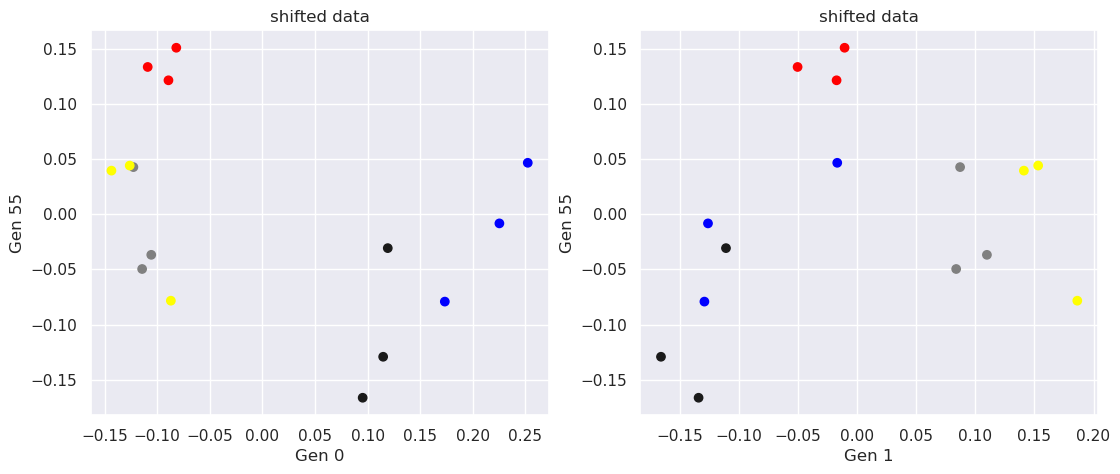

In [31]:
# convert data tomatrix
mat_raw = dat_filt.astype(float)

mean_raw = np.mean(mat_raw,axis = 1)

shifted_raw = (mat_raw.transpose() - mean_raw).transpose()

# Show two pairs of genes together, pick them here:
show_genes = [(0, 55), (1, 55)]
fig, axes = plt.subplots(1, 2, figsize=(13, 5))
for pair, ax in zip(show_genes, axes):
    # Show first pair of genes, the `*` unpacks the two rows selected by `pair`
    ax.scatter(*shifted_raw[pair,:],color=color_cond)
    ax.set_title('shifted data')
    ax.set_xlabel(f'Gen {pair[0]}')
    ax.set_ylabel(f'Gen {pair[1]}')
# mat_raw.shape


### 3) Calculate the covariance matrix

In [32]:
# GET the Covariance matrix, because this is the important matrix!!! 
# it is symmetric
cov_mat = np.cov(shifted_raw)
cov_mat.shape

(1942, 1942)

### 4) calculate the eigenvalues and eigenvectors of the covariance matrix

In [33]:
# get the eigenvector + wert of the 
eigen_val,  eigen_vec = np.linalg.eigh(cov_mat)
#print (eigen_val);
#print (eigen_vec);

# comment: the first eigenvector is found in the first colums belonging to first eigenwert and so on ... 


In [34]:
# these are the eigenvalues from highest
print(eigen_val[-6:])

[ 0.63391639  0.79997758  1.28823255  2.9984116   5.89800282 46.40069796]


In [35]:
idx_sort = np.flip(np.argsort(eigen_val));

# we are only interested in the first XX components
# set how many u are interested in:
maxComponents = len(idx_sort);

idx_sort_OI = idx_sort[0:maxComponents];

# create the feature matrix T_B
TB = np.zeros((len(idx_sort_OI),eigen_vec.shape[1]))
for i in range(0,len(idx_sort_OI)):
    TB[i,:] = eigen_vec[:,idx_sort_OI[i]]


### 5) Derive the new data set :)

Now we have the eigenvectors and eigenwerte to the covariance matrix. We have also sorted them according to highest eigenwert, in order of descending magnitude ($T_B$).


For each condition $i$ we have expression data for all the genes, collected in the column vectors $\overrightarrow{\text{Dat}_i}$. With the eigenvectors collected in a matrix $T_B$ (each eigenvector is one row), we can transform the vectors to the new basis by multiplying vector to matrix: 

$$ \overrightarrow{\text{Dat}}_{\text{i}}' = \begin{pmatrix} ...\vec{e_1}... \\ ...\vec{e_2}... \\ \vdots \\ ...\vec{e_n}... \end{pmatrix} \cdot 
\overrightarrow{\text{Dat}}_{\text{i}} = T_B \cdot \overrightarrow{\text{Dat}}_{\text{i}} $$

This wouldn't really reduce our data set, but we know, that most of the information is contained in a few principal components. So what we do is, we reduce the transformation matrix $T_B$ and cut away all the rows that contain small components. Let's say, we only keep 4 rows. 

$$ \overrightarrow{\text{Dat}}_{\text{i}}' = \begin{pmatrix} ...\vec{e_1}... \\ ...\vec{e_2}... \\ ...\vec{e_3}...  \\ ...\vec{e_4}... \end{pmatrix} \cdot 
\overrightarrow{\text{Dat}}_{\text{i}} $$

In [36]:
data_final = np.dot(TB,shifted_raw)
data_final.shape;

In [37]:
# now get the % of variance that this covers :)
# Iterate over the first 6 variances, unless maxComponents was smaller, then stop earlier of course.
for i in range(min([6, maxComponents])):
    print(f"Variance along axis {i+1}: {np.round(np.var(data_final[i]), 8):11.8f}")
    #                           ^^^^^ depends on how we count             ^^^^^^ Formatting string, not crucial
    
collect_var = np.zeros(maxComponents)
# Elegant way of evaluating the variance, numpy takes an `axis` argument for many functions, 
# which indicates along which axis the function is executed. Here we want `axis=1`, i.e. the second axis.
collect_var = np.var(data_final, axis=1) * len(data_final[0]) / (len(data_final[0]) - 1) 
    
# I think the fraction of the whole variance can be calculated like this ...
frac_of_var  = collect_var / np.sum(collect_var) 
frac_of_var

Variance along axis 1: 43.30731809
Variance along axis 2:  5.50480263
Variance along axis 3:  2.79851749
Variance along axis 4:  1.20235038
Variance along axis 5:  0.74664574
Variance along axis 6:  0.59165529


array([7.84125779e-01, 9.96703985e-02, 5.06701824e-02, ...,
       5.21665242e-29, 2.79498517e-29, 3.54213301e-31])

(-4.0, 6.0)

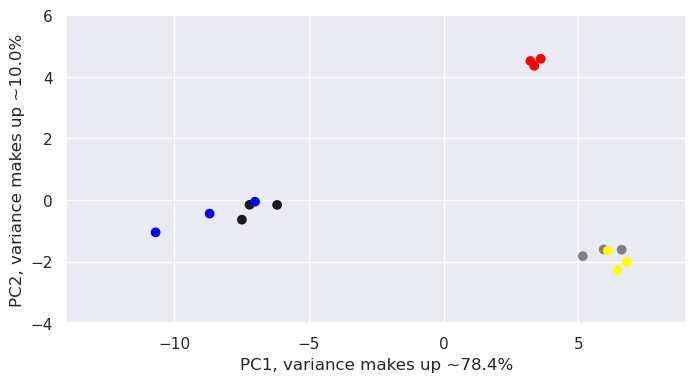

In [38]:
# plot the 2 principle components

def plot_two_PCs(data, pc_indices, variance_fractions):
    i, j = pc_indices
    fig, ax = plt.subplots(1, 1, figsize=(8, 4))
    plt.scatter(data_final[i,:], data_final[j,:], color=color_cond)
    plt.xlabel(f"PC{i+1}, variance makes up ~{np.round(variance_fractions[i]*100, 1)}%")
    plt.ylabel(f"PC{j+1}, variance makes up ~{np.round(variance_fractions[j]*100, 1)}%");
    
plot_two_PCs(data_final, [0, 1], frac_of_var)
plt.xlim([-14,9])
plt.ylim([-4,6])

# Save as a SVG and PNG
#plt.savefig('/home/isabel/Documents/Doktorarbeit_Mai2022/P5_Ngo_fromSciebo/RNA/2022March_Run4/1_Analysis1_naiv/2a_PreAnalysis_woMM/plot_from_python/PCA_20221109.svg')


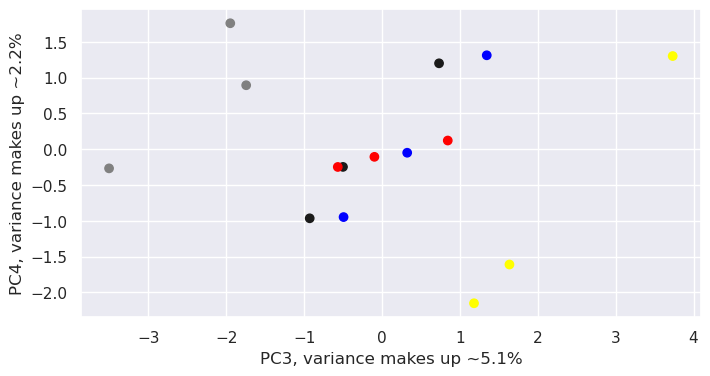

In [39]:
# plot the 3rd and 4th principle components
plot_two_PCs(data_final, [2, 3], frac_of_var)



### 6) Look at the components of the eigenvectors:
- Why should we want to do this?
    - naja, here: $$ \overrightarrow{\text{Dat}}_{\text{i}}' = \begin{pmatrix} ...\vec{e_1}... \\ ...\vec{e_2}... \\ ...\vec{e_3}...  \\ ...\vec{e_4}... \end{pmatrix} \cdot 
\overrightarrow{\text{Dat}}_{\text{i}} $$
    - if one of the "important" eigenvectors has a big component, this means that the impact of the according gene on the component in the new basis will be high


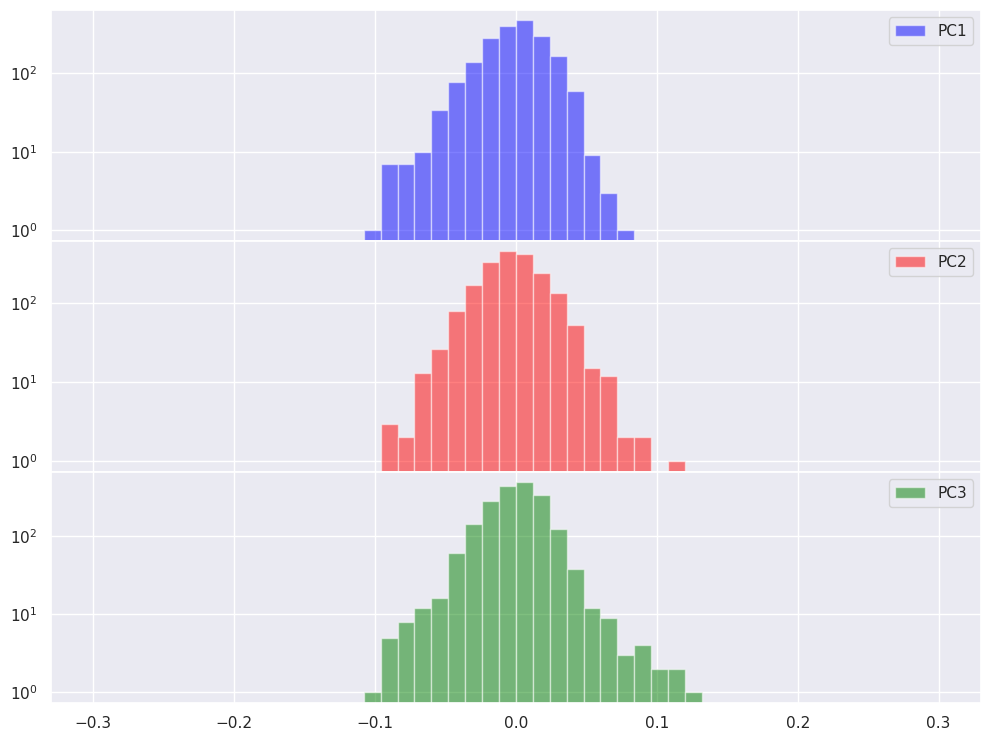

In [40]:

fig, axs = plt.subplots(3, 1, sharex=True, gridspec_kw={"hspace": 0}, figsize=(12, 9))
colors = ["blue", "red", "green"]
for idx, (tb, ax) in enumerate(zip(TB, axs)):
    ax.hist(tb, bins=50, range=[-0.3,0.3], color=colors[idx], alpha=0.5, label=f"PC{idx+1}");
    ax.set(yscale='log')
    ax.legend()


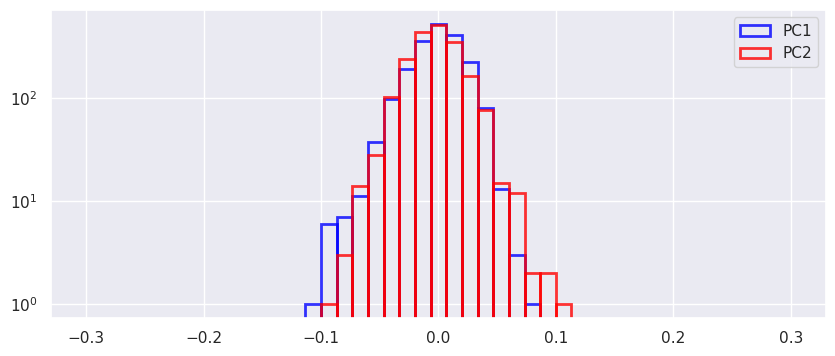

In [41]:
fig, ax = plt.subplots(figsize=(10,4))
colors = ["blue", "red", "green"]

for idx in range(0,2):
    ax.hist(TB[idx], bins=45, range=[-0.3,0.3], ec=colors[idx],  
            color=colors[idx], fc="none", alpha=0.8, label=f"PC{idx+1}", linewidth=2);
    ax.set(yscale='log')
    ax.legend()



#plt.savefig('/home/isabel/Documents/Doktorarbeit_Mai2022/P5_Ngo_fromSciebo/RNA/2022March_Run4/1_Analysis1_naiv/2a_PreAnalysis_woMM/plot_from_python/PC1_PC2_hist.svg')


In [42]:
# get the eigenvectors whith the highest entries 
idx_outliers_PC1 = np.argsort(np.abs(TB[0]))[::-1][0:100]
gen_outliers_PC1 = geneNames_filt[idx_outliers_PC1]
print(TB[0][idx_outliers_PC1])
print(gen_outliers_PC1)
print(idx_outliers_PC1)

idx_outliers_PC2 = np.argsort(np.abs(TB[1]))[::-1][0:100]
gen_outliers_PC2 = geneNames_filt[idx_outliers_PC2]
#print(TB[1][idx_outliers_PC2])
#print(idx_outliers_PC2)

[-0.1014346  -0.09171023 -0.09085358 -0.08863726 -0.08852725 -0.08781487
 -0.08769178 -0.08412094 -0.08309511 -0.08210966 -0.08166397  0.08150377
 -0.08098056 -0.07719219 -0.07441411 -0.07259935  0.0716605  -0.07150446
 -0.06943374 -0.06861663 -0.06730087 -0.06704773  0.06620804 -0.06179028
 -0.06172539 -0.06141405 -0.06122901  0.06091505 -0.06085545 -0.05998489
 -0.05986733 -0.0598437  -0.05975145 -0.05938235 -0.05854515 -0.05780093
 -0.05767456 -0.05725769 -0.05725122  0.05669721 -0.05643525 -0.05630091
 -0.05614581 -0.05602017 -0.05565414 -0.05557182 -0.05444588 -0.05371097
 -0.05362272 -0.05357318 -0.05346561  0.05319592  0.05294734 -0.05259748
  0.05224049 -0.05205727 -0.05184803 -0.05166418  0.05137137 -0.05108061
 -0.05036028  0.04994515 -0.04947556 -0.04924626 -0.04885477 -0.04883459
  0.04882396 -0.0488239  -0.04881298 -0.04850862  0.04815364  0.04803116
  0.04755547 -0.04748462  0.04699754  0.0469007  -0.04682077  0.04674029
 -0.04668032 -0.04655478 -0.04649993  0.04646912  0

In [43]:
# find the genes that are beyond the 95% part of the distribution
box      = np.zeros([2,2]);

outlier_sortAbs= [];
outlier_idx    = [];
for i in range(0,2):
    box[i]  = [np.mean(TB[i]) - 2*np.std(TB[i]),np.mean(TB[i]) + 2*np.std(TB[i])]
    outlier_bool = [np.logical_or(TB[i] > box[i][1],TB[i] < box[i][0])]
    #outlier_idx  = outlier_bool.nonzero()
    #outlier_value= TB[i][outlier_bool]
    #outlierVal = TB[i][outlier]
    #outlier_sortAbs.append(np.argsort(np.abs(outlier[i])))
    #outlier_idx.append(np.where(outlier_sortAbs[i]))
A = np.array([[1,2,3,4,5],[6,2,7,3,8],[6,2,7,3,8]])
AA = (A > 3).nonzero()
    #print(outlier_bool.nonzero())
#print([np.mean(TB[0]) - 2*np.std(TB[0]),np.mean(TB[0]) + 2*np.std(TB[0])])
AA

(array([0, 0, 1, 1, 1, 2, 2, 2]), array([3, 4, 0, 2, 4, 0, 2, 4]))

In [44]:
# do some small analysis with the genes that fall out here:
# 1. do PC1 and PC2 overlap?

np.intersect1d(gen_outliers_PC1,gen_outliers_PC2)

array(['gene-NGFG_00081', 'gene-NGFG_00464', 'gene-NGFG_00598',
       'gene-NGFG_00629', 'gene-NGFG_00699', 'gene-NGFG_00708',
       'gene-NGFG_00826', 'gene-NGFG_00840', 'gene-NGFG_00841',
       'gene-NGFG_00845', 'gene-NGFG_01163', 'gene-NGFG_01284',
       'gene-NGFG_01291', 'gene-NGFG_01292', 'gene-NGFG_01315',
       'gene-NGFG_01369', 'gene-NGFG_01370', 'gene-NGFG_01491',
       'gene-NGFG_01540', 'gene-NGFG_02170'], dtype='<U15')


# Do it with a built-in function!!


In [45]:
shifted_raw[0:100,:].T.shape

(15, 100)

In [46]:

pca = PCA(n_components=4)
pca.fit(shifted_raw[100:300,:].T)
PCA(n_components=4)
print(pca.explained_variance_ratio_)
#print(pca.components_)
#eigen_val / np.sum(eigen_val)
pca.explained_variance_ratio_[0]
shifted_raw.T.shape

[0.80280757 0.08773478 0.04953048 0.01736381]


(15, 1942)

Text(0, 0.5, 'PC1, variance makes up ~9%')

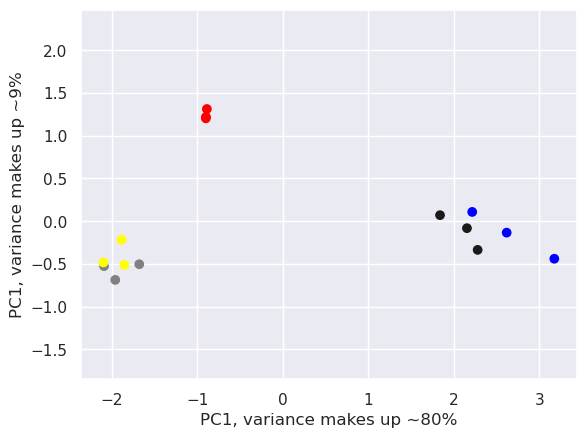

In [47]:
dat_pca = pca.transform(shifted_raw[100:300,:].T)
# plot_two_PCs(dat_pca.T, [0, 1], pca.explained_variance_ratio_)
plt.scatter(dat_pca[:, 0], dat_pca[:, 1],color=color_cond)
plt.axis('equal');
plt.xlabel("PC1, variance makes up ~" + str(round(pca.explained_variance_ratio_[0]*100)) + "%")
plt.ylabel("PC1, variance makes up ~" + str(round(pca.explained_variance_ratio_[1]*100)) +  "%")
